# Exploratory Data Analysis With Basic Model

The data set is quite strange in how it is tabulated. Each column is a year. Every day a new value for the previous day is added but the earliest value is deleted meaning there is a limit to how many values the TSA publishes to its website simultaneously.

The data is tabulated so that one can compare the number of flights on the same date of the previous year. As such, it is not arranged chronologically. We will have to mess with some date reformatting to get the data to it's desired format.

In [242]:
import pandas as pd

In [243]:
df = pd.read_csv("Data1.csv")

## Formatting and Cleaning Data [Boring Feel Free To Skip]

Our first goal is to change the data into a time series format, we have to build date-sequences, and then overlay them onto the correct years. 

If you examine the data from the TSA website, you will notice that each year's column begins in the previous year and ends in the current year. Therefore, our data begins from 2018.

In [244]:
df.head()

,Unnamed: 0,Date,2023,2022,2021,2020,2019
0,0,4/10/2023,"2,511,861","2,188,196","1,468,972","102,184","2,484,580"
1,1,4/9/2023,"2,375,705","2,300,909","1,561,495","90,510","2,446,801"
2,2,4/8/2023,"2,093,075","1,959,523","1,378,237","93,645","2,059,142"
3,3,4/7/2023,"2,475,368","2,327,849","1,549,181","108,977","2,590,499"
4,4,4/6/2023,"2,508,487","2,227,151","1,510,829","104,090","2,487,398"


First we create our own date ranges labeled with the correct year since the date column in the original data only contains 2022-2023 dates. We use pandas date ranges in order to do this.

The original data does not contain the leap-day (2020 was a leap year) so we have to remove this day from our 2020 date range.

In [245]:
pd.to_datetime(df["Date"].iloc[0])

Timestamp('2023-04-10 00:00:00')

In [246]:
#Converts a date in the form of a string to 
#date: date in form of string with mm/dd/yyyy
#year: in form of string to a timestamp with the desired year
def format_date(date, year):
    date_list = date.split("/")
    date_list[2] = year
    date = "/".join(date_list)
    date = pd.to_datetime(date)
    return date

In [248]:
def format_to_ts(df, years, truncated_year):
    ts_df = pd.DataFrame({"Date": [], "Checkins": []})
    for year in years:
        #Use our formatting function in a lambda so we can map it on the dataframe
        x = lambda date: format_date(date, year)
        curr_df = df[["Date",year]]
        curr_df["Date"] = curr_df["Date"].map(x)
        curr_df.rename(columns = {year: "Checkins"}, inplace = True)
        ts_df = ts_df.append(curr_df)
    #drops the nan values
    x = lambda date: format_date(date, truncated_year)
    truncated_df = df[["Date", truncated_year]]
    truncated_df.dropna(inplace = True)
    truncated_df["Date"] = truncated_df["Date"].map(x)
    truncated_df.rename(columns = {truncated_year : "Checkins"}, inplace = True)
    ts_df = ts_df.append(truncated_df)
    ts_df = ts_df.sort_values(by = "Date")
    return ts_df

In [249]:
#Formats the comma separated string number into an integer
def to_int(s):
    if s == 'nan':
        return 'nan'
    s = str(s)
    return int(s.replace(",",""))

In [250]:
years = ["2019", "2020", "2021", "2022"]
truncated_year = "2023"

In [251]:
ts_df = format_to_ts(df, years, truncated_year)

<ipython-input-248-db06c96d2c45>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-248-db06c96d2c45>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-248-db06c96d2c45>:9: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

<ipython-input-248-db06c96d2c45>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [252]:
ts_df["Checkins"] = ts_df["Checkins"].map(to_int)

In [253]:
ts_df

,Date,Checkins
99,2019-01-01,2202111
98,2019-01-02,2150571
97,2019-01-03,1975947
96,2019-01-04,2229391
95,2019-01-05,2044043
...,...,...
4,2023-04-06,2508487
3,2023-04-07,2475368
2,2023-04-08,2093075
1,2023-04-09,2375705


In [254]:
import plotly.express as pt

## Exploratory Analysis

In [257]:
pt.line(ts_df, x = "Date", y = "Checkins",title = "TSA Checkins vs Time")

In [258]:
ts_df.to_csv("TSACheckinTS.csv")

### Checkins by Month

In [265]:
x = lambda date: date.month
ts_df["Month"] = ts_df["Date"].map(x)

In [268]:
checkins_by_month = ts_df.groupby(["Month"]).mean()

In [285]:
pt.bar(checkins_by_month, checkins_by_month.index,y =  "Checkins", title = "Average Checkins by Month")

### Average Check-ins by Month ex Covid
Now let's filter out the covid data since it was an abnormality. Eyeing our time series plot from above, we can filter out data between March 3rd 2020 and June 26th 2021

In [288]:
flag = (ts_df["Date"] <= pd.to_datetime("2020-03-06")) | (ts_df["Date"] >= pd.to_datetime("2020-06-26"))
ts_df_ex_covid = ts_df[flag]

In [295]:
checkins_by_month = ts_df_ex_covid.groupby(["Month"]).mean()

In [296]:
pt.bar(checkins_by_month, checkins_by_month.index, y = "Checkins", title = "Average Checkins by Month (Ex Covid)")

We can see covid pulled down averages for some of the months

## Distribution of Checkin Numbers (Ex Covid)

We have a right-skewed distribution with a fat tail on the left. The histogram with covid removed is a more realistic representation of the underlying distribution.

In [299]:
pt.histogram(ts_df_ex_covid,"Checkins", nbins = 100, histnorm = "probability")

### Autocorrelation of Checkins

We have an autocorrelation plot of the entire data set

In [301]:
from matplotlib import pyplot as plt

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

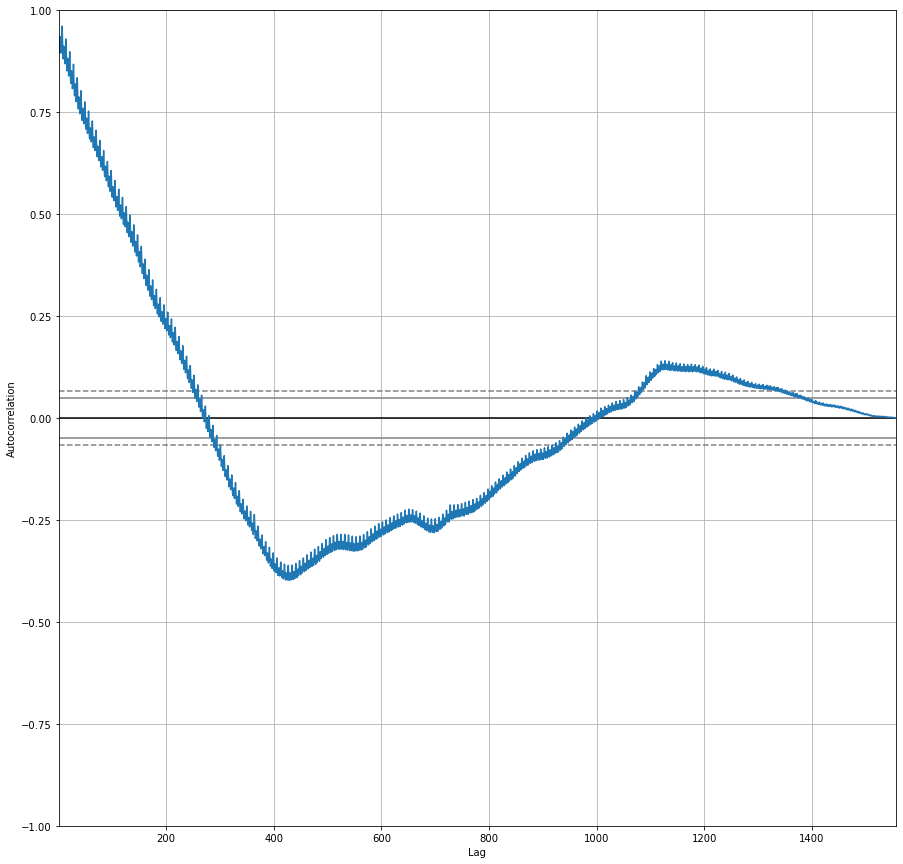

In [303]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)

pd.plotting.autocorrelation_plot(ts_df.Checkins)

There is significant auto-correlation between the 0 and 200 lag! This is good news. This suggests there is information we can capture in our time series model.

Now we will fit a basic ARIMA(p,d,q) time series model and create some forecasts.

In [304]:
#!pip install pmdarima

  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.1
    Uninstalling patsy-0.5.1:
      Successfully uninstalled patsy-0.5.1
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc3 3.11.5 requires numpy<1.22.2,>=1.15.0, but you have numpy 1.24.2 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.10.1 which is incompatible.


In [307]:
from pmdarima.arima import auto_arima, ADFTest

In [314]:
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(ts_df[["Checkins"]])

(0.5577479177924815, True)

In [319]:
X_train = ts_df[0:1244][["Date", "Checkins"]]
X_test = ts_df[1244:][["Date", "Checkins"]]

In [325]:
from pmdarima.arima.utils import ndiffs

In [326]:
n_adf = ndiffs(X_train["Checkins"], test="adf")

In [327]:
n_adf

1

In [354]:
arima_model = auto_arima(X_train["Checkins"], start_p = 0, d = 1, start_q = 0, max_p = 10, max_d = 5, max_q = 1, start_P = 0, D = 1, start_Q = 0, max_P=5, max_D = 5, max_Q = 5, m = 12, seasonal = True, error_action = "warn", trace = True, stepwise = True, random_state = 20, n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=35408.715, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=34702.429, Time=1.78 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=2.73 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=35361.079, Time=0.20 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=34618.417, Time=3.17 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=34616.091, Time=6.74 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=34548.647, Time=12.61 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=34550.302, Time=29.79 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=34524.825, Time=21.68 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=inf, Time=20.79 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=34526.755, Time=48.79 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=24.96 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=inf, Time=14.39 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=inf, Time=63.66 sec
 ARIMA(0,1,0)(4,1,1)[12]   

In [355]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 1244
Model:             SARIMAX(0, 1, 0)x(5, 1, [1], 12)   Log Likelihood              -17008.350
Date:                              Wed, 12 Apr 2023   AIC                          34030.701
Time:                                      20:56:53   BIC                          34066.510
Sample:                                           0   HQIC                         34044.173
                                             - 1244                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -1.5285      0.088    -17.428      0.000      -1.700      -1.357
ar.S.L24      -1.0202      0.095    -10.732      0.000      -1.207      -0.834
ar.S.L36      -0.6914      0.067    -10.376      0.000      -0.822      -0.561
ar.S.L48      -0.6036      0.067     -8.983      0.000      -0.735      -0.472
ar.S.L60      -0.1403      0.058     -2.437      0.015      -0.253      -0.027
ma.S.L12       0.6692      0.080      8.416      0.000       0.513       0.825
sigma2      5.823e+10   6.88e-13   8.46e+22      0.000    5.82e+10    5.82e+10
===================================================================================
Ljung-Box (L1) (Q):                  68.48   Jarque-Bera (JB):                85.78
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.40
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.96e+39. Standard errors may be unstable.
"""

In [356]:
forecast = []
for i in arima_model.predict(n_periods = 312):
    forecast.append(i)

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



In [357]:
X_test["Forecast"] = forecast

In [358]:
X_test

,Date,Checkins,Forecast
311,2022-06-03,2332592,2.051785e+06
310,2022-06-04,1981408,1.943711e+06
309,2022-06-05,2387196,2.118734e+06
308,2022-06-06,2279743,2.271623e+06
307,2022-06-07,2052377,2.084982e+06
...,...,...,...
4,2023-04-06,2508487,1.737392e+06
3,2023-04-07,2475368,1.845405e+06
2,2023-04-08,2093075,1.772333e+06
1,2023-04-09,2375705,1.802427e+06


In [360]:
pt.line(X_test, x = "Date", y = ["Checkins", "Forecast"],title = "Forecast vs Actual")